In [2]:
from qutip import *
import numpy as np

In [3]:
# Defining the system Hamiltonian
eps = 0.2    # Energy of the 2-level system.
Del = 0   # Tunnelling term
Hsys = 0.5 * eps * sigmaz() + 0.5 * Del * sigmax()
# Initial state of the system.
rho0 = basis(2, 0) * basis(2, 0).dag()
tlist=np.linspace(0,10,1000)

## Spectral density fitting

In [4]:
w = np.linspace(0, 20, 20000)
def ohmic_spectral_density(w, alpha, wc):
    """ The Ohmic bath spectral density as a function of w
        (and the bath parameters).
    """
    return w * alpha * np.e**(-w / wc)

In [24]:
alpha=0.05
T=1
wc=0.5

In [25]:
J=ohmic_spectral_density(w,alpha,wc)

In [26]:
import cProfile as cp

In [27]:
obp=heom.FitSpectral(T, sigmax(), nk=4)

In [28]:
obp.get_fit(J,w,final_rmse=1e-6)

KeyboardInterrupt: 

In [ ]:
options = {'nsteps':15000, 'store_states':True, 'rtol':1e-12, 'atol':1e-12, 'method':"bdf"}
HEOM_spectral_fit = heom.HEOMSolver(Hsys, obp.Bath_spec, max_depth=4, options=options,)
result_spectral=HEOM_spectral_fit.run(rho0,tlist)

10.0%. Run time:   0.27s. Est. time left: 00:00:00:02
20.0%. Run time:   0.58s. Est. time left: 00:00:00:02
30.0%. Run time:   0.94s. Est. time left: 00:00:00:02
40.0%. Run time:   1.21s. Est. time left: 00:00:00:01
50.1%. Run time:   1.42s. Est. time left: 00:00:00:01
60.1%. Run time:   1.67s. Est. time left: 00:00:00:01
70.1%. Run time:   1.92s. Est. time left: 00:00:00:00
80.1%. Run time:   2.15s. Est. time left: 00:00:00:00
90.1%. Run time:   2.38s. Est. time left: 00:00:00:00
100.0%. Run time:   2.63s. Est. time left: 00:00:00:00
Total run time:   2.63s


In [ ]:
obp.summary()

Fit Spectral instance: 
 Results of the fitting: 
 Parameters   lam      gamma      w0 
           -4.42e-02  4.30e+00 4.62e+00 
           9.57e-01  1.71e+00 1.75e+00 
           1.12e-03  5.66e-01 1.00e-01 
           4.10e-02  1.49e+00 1.00e-01 
          -8.92e-01  1.69e+00 1.77e+00 
           1.41e-05  1.41e-01 1.00e-01 
A  normalized RMSE of  9.783549e-07 was obtained for the spectral density 
A total of 7 underdamped modes where usedThe current fit took 336.953001499176


## Correlation Function Fitting

In [ ]:
from mpmath import mp
alpha=0.05
T=1
wc=1

In [ ]:
def ohmic_correlation(t, alpha, wc, beta, s=1):
    """ The Ohmic bath correlation function as a function of t
        (and the bath parameters).
    """
    corr = (
        (1 / np.pi) * alpha * wc**(1 - s) * beta**(-(s + 1)) * mp.gamma(s + 1)
    )
    z1_u = (1 + beta * wc - 1.0j * wc * t) / (beta * wc)
    z2_u = (1 + 1.0j * wc * t) / (beta * wc)
    # Note: the arguments to zeta should be in as high precision as possible.
    # See http://mpmath.org/doc/current/basics.html#providing-correct-input
    return np.array([
        complex(corr * (mp.zeta(s + 1, u1) + mp.zeta(s + 1, u2)))
        for u1, u2 in zip(z1_u, z2_u)
    ], dtype=np.complex128)

In [ ]:
C=ohmic_correlation(tlist,alpha,wc,1/T)

In [ ]:
obp2=heom.FitCorr(sigmax())

In [ ]:
obp2.fit_correlation(tlist,C,final_rmse=1e-6)

In [ ]:
obp2.summary()

Fit correlation instance: 
 Results of the fitting the Real Part: 
 Parameters   lam      gamma      w0 
            3.52e-02 -1.66e+00 7.84e-05 
           1.73e-03 -1.77e-01 3.19e-06 
           4.51e-03 -2.75e+00 3.82e+00 
           2.83e-01 -3.25e+00 2.41e+00 
          -3.01e-01 -3.32e+00 2.46e+00 
           1.27e-02 -6.56e-01 6.20e-06 
A  normalized RMSE of  8.886421e-07 was obtained for the real part 
Results of the fitting the Imaginary Part: 
 Parameters   lam      gamma      w0 
          -2.97e-02 -1.66e+00 9.65e-01 
          -5.30e-03 -1.71e+00 2.09e+00 
          -8.86e-04 -1.71e+00 3.18e+00 
           3.59e-03 -4.34e+00 4.99e+00 
          -3.58e-02 -4.01e-01 4.61e-03 
          -5.17e-02 -1.10e+00 1.37e-01 
A  normalized RMSE of 7.59e-07 was obtained for the imaginary part 
The current fit took -521.3807032108307


In [ ]:
options = {'nsteps':15000, 'store_states':True, 'rtol':1e-12, 'atol':1e-12, 'method':"bdf"}
HEOM_corr_fit = heom.HEOMSolver(Hsys, obp2.Bath_corr, max_depth=4, options=options,)
result_corr=HEOM_corr_fit.run(rho0,tlist)

10.0%. Run time:   2.25s. Est. time left: 00:00:00:20
20.0%. Run time:   2.98s. Est. time left: 00:00:00:11
30.0%. Run time:   3.71s. Est. time left: 00:00:00:08
40.0%. Run time:   4.40s. Est. time left: 00:00:00:06
50.1%. Run time:   4.94s. Est. time left: 00:00:00:04
60.1%. Run time:   5.49s. Est. time left: 00:00:00:03
70.1%. Run time:   5.99s. Est. time left: 00:00:00:02
80.1%. Run time:   6.58s. Est. time left: 00:00:00:01
90.1%. Run time:   7.20s. Est. time left: 00:00:00:00
100.0%. Run time:   7.82s. Est. time left: 00:00:00:00
Total run time:   7.82s


# Comparison between fits

In [ ]:
def projection(result,i,j):
    return [result.states[k][i,j] for k in range(len(result.states))]

In [ ]:
import matplotlib.pyplot as plt

/home/mcditoos/anaconda3/envs/qutip-dev/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/mcditoos/anaconda3/envs/qutip-dev/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


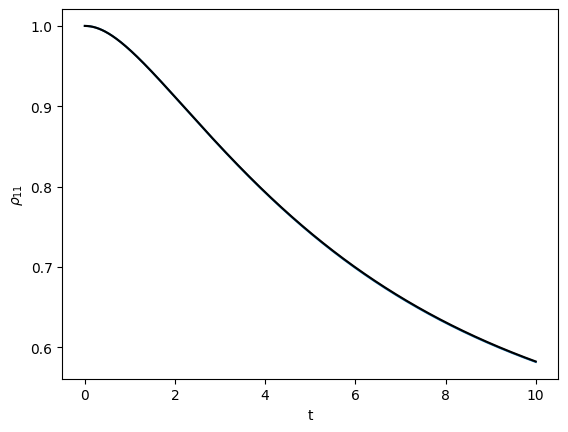

In [ ]:
plt.plot(tlist,projection(result_corr,0,0))
plt.plot(tlist,projection(result_spectral,0,0),color='k')
plt.xlabel('t')
plt.ylabel(r'$\rho_{11}$')
plt.show()

In [ ]:
def ohmic_power_spectrum(w, alpha, wc, beta):
    """ The Ohmic bath power spectrum as a function of w
        (and the bath parameters).
    """
    return (
        w * alpha * np.e**(-abs(w) / wc) *
        ((1 / (np.e**(w * beta) - 1)) + 1) * 2
    )

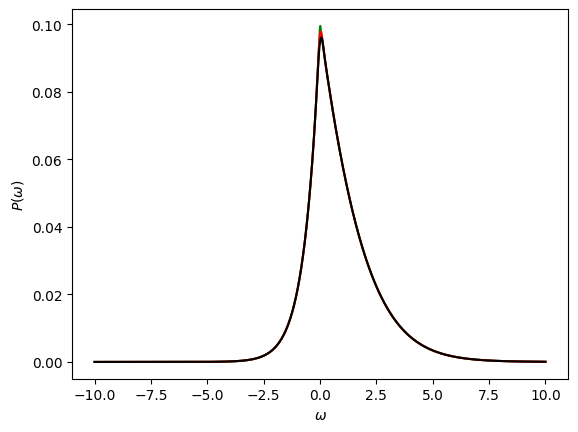

In [ ]:
w=np.linspace(-10,10,1000)
plt.plot(w,ohmic_power_spectrum(w,alpha,wc,1/T),color='green')
plt.plot(w,obp2.corr_spectrum_approx(w),color='red')
plt.plot(w,obp.spec_spectrum_approx(w),color='k')
plt.ylabel(r'$P( \omega )$')
plt.xlabel(r'$\omega$')
plt.show()